In [1]:
!pip -q install tensorflow tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_val), info = tfds.load(
    "rock_paper_scissors",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
print(num_classes, class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PA9FMX_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PA9FMX_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
3 ['rock', 'paper', 'scissors']


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, depth=num_classes)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_ds = (ds_train
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (ds_val
          .map(preprocess, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Transfer learning: freeze feature extractor

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,947 (8.65 MB)

 Trainable params: 6,403 (25.01 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
]

In [6]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.7760 - loss: 0.5786 - val_accuracy: 0.9624 - val_loss: 0.2175
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9734 - loss: 0.0709 - val_accuracy: 0.8952 - val_loss: 0.2755
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9898 - loss: 0.0427 - val_accuracy: 0.8844 - val_loss: 0.4194
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9913 - loss: 0.0286 - val_accuracy: 0.8683 - val_loss: 0.5238


In [7]:
base_model.trainable = True

# Freeze layer bawah, unfreeze layer atas
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.8443 - loss: 0.3693 - val_accuracy: 0.9086 - val_loss: 0.2117
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9557 - loss: 0.1210 - val_accuracy: 0.8898 - val_loss: 0.2468
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9816 - loss: 0.0654 - val_accuracy: 0.8844 - val_loss: 0.2735
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.9862 - loss: 0.0379 - val_accuracy: 0.8790 - val_loss: 0.3218


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


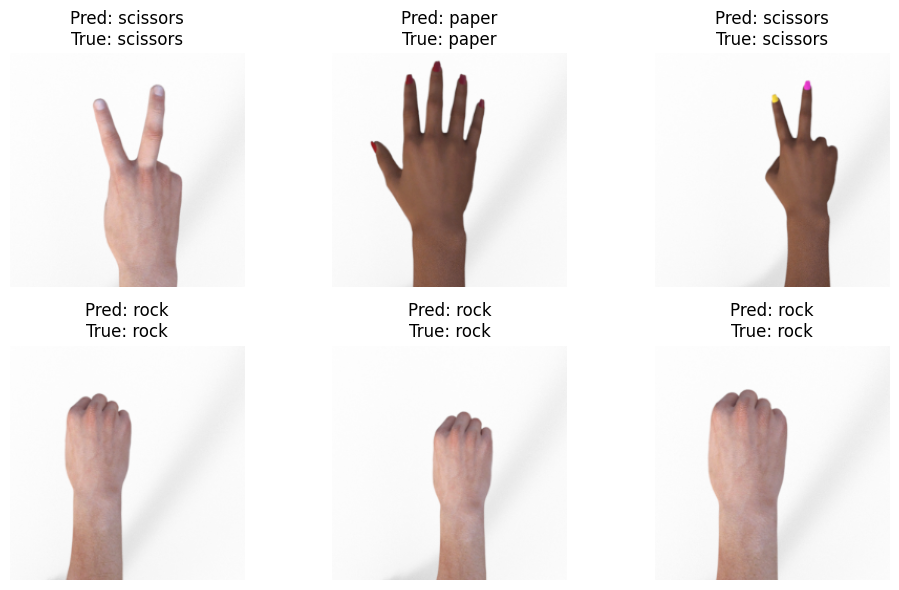

In [8]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels.numpy(), axis=1)

plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()